# EEU4C16/EEP5C16 Lab 7 - Fast Single Image Super-Resolution

## Background
Super-resolution is a technique in image and video processing whereby a low resolution (LR) image/video frame is upsampled to a higher resolution (HR). This has numerous applications for:

- Balancing image/video quality and transmission efficiency for websites.

- Upscaling of photos taken on mobile devices ([Google Research Blog - Enhance! RAISR Sharp Images with Machine Learning](https://research.google/blog/enhance-raisr-sharp-images-with-machine-learning/)).

- Upscaling of video games ([NVIDIA - DLSS 4](https://www.nvidia.com/en-us/geforce/technologies/dlss/)).

Fast super-resolution is of utmost importance for real-time applications and a number of companies are looking into this: [Qualcomm - QuickSRNet: Plain Single-Image Super-Resolution Architecture for Faster Inference on Mobile Platforms](https://openaccess.thecvf.com/content/CVPR2023W/MobileAI/papers/Berger_QuickSRNet_Plain_Single-Image_Super-Resolution_Architecture_for_Faster_Inference_on_Mobile_CVPRW_2023_paper.pdf)

## Your Task
Train a super-resolution model to up-sample image patches from $32\times32$ to $128\times128$ (a factor of $\times4$) and get as close to real-time processing as possible (take this to mean processing a $30$ $fps$ video stream which means your model inference time should be close to $1/30$ seconds $~0.03$ $s$).

**Data Pre-Processing Requirements:**

1. You will be given a training dataset that is represenatitve of the target upsampling distribution (you may want to augment this with other datasets you can find online).

2. You will have to downsample these images and use them as input to the super-resolution neural network.

3. Generate an approriate training/test split from your dataset.

**Architecture Requirements:**

1. Design and train a deep neural network architecture that finds a tradeoff between speed and accuracy.

2. You will need to implement the model class (`SuperResolutionModel`) in (`models.py`) and save the model weights as `model.pth` (**these class and filenames must be left unchanged**).

Finally you will create a report on your data processing/network design process. Try and create some nice informative graphs, images and tables for this.

## Important Notes (Read Carefully!)
- The evaluation on the server will record measures of [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio), [SSIM](https://en.wikipedia.org/wiki/Structural_similarity_index_measure), as well as parameter count (should be **below 5 million params**). You should talk about efficiency runtime etc. in your report. Note that you are free to consider other image quality metrics. You can do some research about these other metrics and consider them for discussion in your report. You can also consider loss functions that go beyond the simple $L_1$/$L_2$ losses.

- Note that the human visual system is more sensitive to changes in luminance
  than chrominance ([Wikipedia - Luma
  (video)](https://en.wikipedia.org/wiki/Luma_(video))). You can take advantage
  of this.

- If you choose to use you own dataset you must save it to a directory on the
  Colab VM as we have done in the cell below i.e.
  `/home/tcd/super_resolution/dataset.npz`, **DO NOT** save it anywhere in the
  `4c16-labs/code` directory as it will affect the whole git system.

- If you are making your own dataset, please chose seperate temporory working
  directory outside `4c16-labs/code`. You could make as `4c16-labs/dataset` to
  store. You CANNOT train and use dataset directly from Google Drive, you SHOULD
  move to Google Colab VM dataset (eg. `home/tcd/super_resolution` ) every session.

- There are different conventions for specifying the dimensions of input/output tensors i.e. $(B, H, W, C)$ or $(B, C, H, W)$ where:    
    - $B=$ batch index
    - $H=$ image height
    - $W=$ image width
    - $C=$ image channels (generally $3$ e.g. $RGB$, $YUV$)

- We expect your network to have $(B, C, H, W)$ (channel first convention used by torch layers) as the input and output tensor dimensions

- Your score for this lab is not directly tied to your performance on the backend. It will be a combination of your network performance and how you present your design in the interview.

In [1]:
# This cell mounts Colab to your Google Drive and navigates to the script directory
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-07/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/4c16-labs/code/lab-07


In [2]:
# Create a .gitignore file to avoid committing large files to git accidentlly
# You should run this cell only once at start of the lab.
# c.f. https://git-scm.com/docs/gitignore
%%writefile .gitignore
*.pyc
__pycache__/
.png
.jpg
.zip
.tar
.tar*

Overwriting .gitignore


In [ ]:
# Download the dataset (should take about ~2 minutes, 617MB)
!curl --create-dirs -o /home/tcd/super_resolution/dataset.npz https://tcddeeplearning.blob.core.windows.net/deeplearning202324/hr_images.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 93  617M   93  575M    0     0  3998k      0  0:02:38  0:02:27  0:00:11 4559k

In [ ]:
# Download new extra images
import numpy as np
npz_files = [
    "/content/gdrive/MyDrive/4th Year 25-26/1st Semester/Deep Learning/Lab7Files/dog_images.npz",
    "/content/gdrive/MyDrive/4th Year 25-26/1st Semester/Deep Learning/Lab7Files/bird_images.npz",
    "/content/gdrive/MyDrive/4th Year 25-26/1st Semester/Deep Learning/Lab7Files/flower_images.npz"
]

all_images = []
for file in npz_files:
    data = np.load(file)
    all_images.append(data['images'])
all_images = np.concatenate(all_images, axis=0)
print("Combined images shape:", all_images.shape)

In [ ]:
# Import necessary functions libraries
import numpy as np
# Neural Networks:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Plotting:
import matplotlib.pyplot as plt
%matplotlib inline
# Metrics:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import rescale # For downsampling!
# Extra:
import random
from tqdm import tqdm
import time
# Import our model definition (if you get a module import error make sure your
# current working directory is the script directory is 4c16-labs/code/lab-07/
# from your Google Drive
from models import SuperResolutionModel

# Dataset pre-processing
Here we load the dataset we have provided from a Numpy compressed (`.npz`) file. It's up to you to pre-process the dataset.

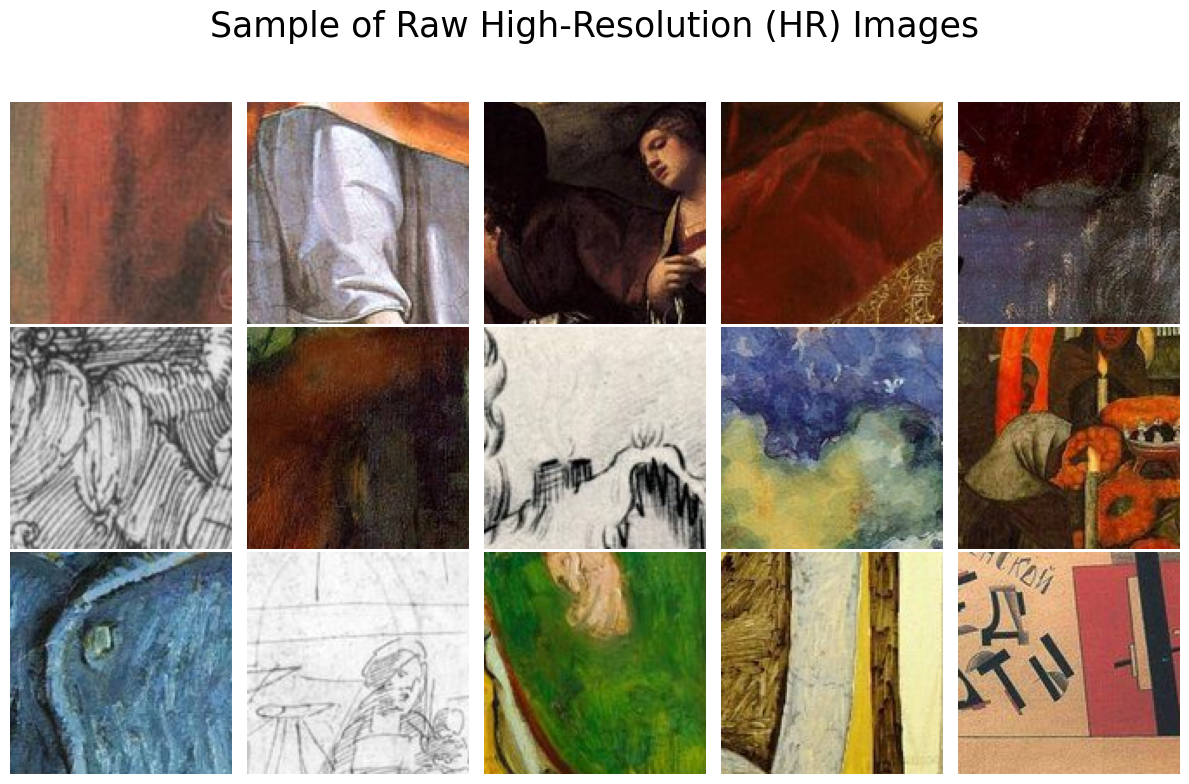

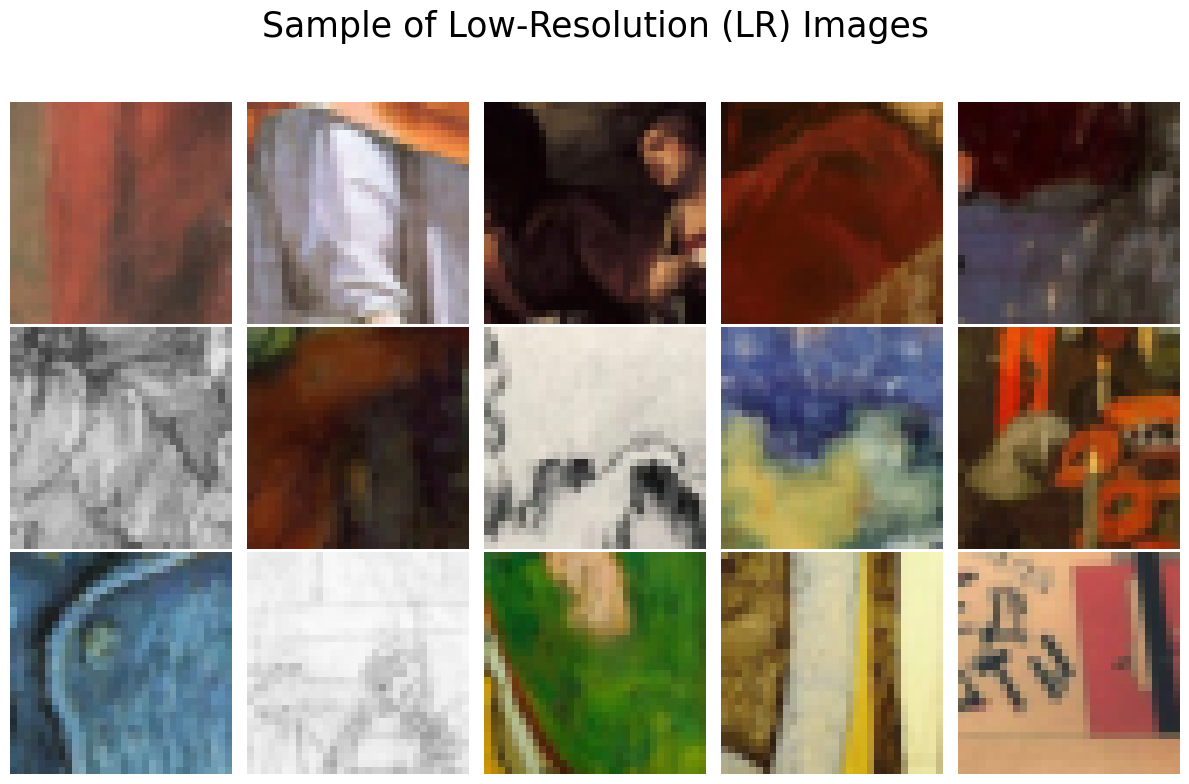

In [ ]:
# Loads raw HR dataset:
hr_images_orig = np.load(f'/home/tcd/super_resolution/dataset.npz')['hr_images']
print("Original HR images shape:", hr_images_orig.shape)
print("New images shape:", all_images.shape)
# Combine the two datasets:
hr_images = np.concatenate([hr_images_orig, all_images], axis=0)
print("Combined HR images shape:", hr_images.shape)
# Normalise for display:
imgs = hr_images.astype(np.uint8)
# Show first 15 images:
plt.figure(figsize=(12, 8))
plt.suptitle("Sample of Raw High-Resolution (HR) Images", fontsize = 25)
for i in range(15):
  plt.subplot(3, 5, i+1)
  plt.imshow(imgs[i])
  plt.axis('off')
plt.tight_layout(rect = [0,0,1,0.95])
plt.show()
# Your input/output images should have pixel values in the range [0, 1]
# For 8-bit images the max. pixel value is 255
hr_images = hr_images / 255.0
hr_images = hr_images.astype(np.float32)
# Downsample each image with something like skimage.transform rescale function (https://scikit-image.org/docs/0.25.x/api/skimage.transform.html#skimage.transform.rescale)
#   This would be something like:
#   lr_images = rescale(hr_images, scale_factor, etc..))
# Then pair each high-res (grounn truth) with it's downsampled low-res counterpart
lr_images = np.array([rescale(img, scale=0.25, anti_aliasing=True, channel_axis=-1) for img in hr_images])
# Save paired LR-HR dataset for later use in Dataset
np.savez('/home/tcd/super_resolution/hr_lr_pairs.npz', hr_images = hr_images, lr_images = lr_images)
# Display only first 15 LR images
lr_images_display = (lr_images[:15]*255).astype(np.uint8)
plt.figure(figsize=(12, 8))
plt.suptitle("Sample of Low-Resolution (LR) Images", fontsize = 25)
for i in range(15):
  plt.subplot (3, 5, i+1)
  plt.imshow(lr_images_display[i])
  plt.axis('off')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# Defining the Dataset Generator and Dataloader
Next we define the dataloader which will give us an iterable object of high-resolution and low-resolution image pairs to use in our training loop. You can define data augmentation strategies to randomly flip image pairs, shift pixel values etc.

In [ ]:
class SuperResolutionDataset(Dataset):
    def __init__(self, npz_file_path, augment = False):
        """Load tensors from hr_lr_pairs.npz file."""
        data = np.load(npz_file_path)
        self.hr_images = data['hr_images']
        self.lr_images = data['lr_images']
        self.augment = augment
    def __len__(self):
        return len(self.hr_images)
    def __getitem__(self, idx):
        # Convert numpy arrays to PyTorch tensors (using torch library)
        # lr = torch.from_numpy(self.lr_images[idx]).permute(2, 0, 1)  # HWC → CHW
        # hr = torch.from_numpy(self.hr_images[idx]).permute(2, 0, 1)
        lr = self.lr_images[idx]
        hr = self.hr_images[idx]
        # AUGMENTATIONS
        if self.augment:
          # Random flip:
          if random.random() < 0.5:
            lr = np.flip(lr, axis = 1)
            hr = np.flip(hr, axis = 1)
          # Random vertical flip:
          if random.random() < 0.5:
            lr = np.flip(lr, axis = 0)
            hr = np.flip(hr, axis = 0)
          # Random rotation (0, 90, 180, 270)
          k = random.choice([0,1,2,3])
          lr = np.rot90(lr, k)
          hr = np.rot90(hr,k)
        # Convert to tensor (CHW format)
        lr = torch.from_numpy(lr).permute(2,0,1).float()
        hr = torch.from_numpy(hr).permute(2,0,1).float()
        return lr, hr
        #return lr.float(), hr.float()
        # return self.lr_images[idx], self.hr_images[idx]
# training_dataset = SuperResolutionDataset('/home/tcd/super_resolution/hr_lr_pairs.npz', augment = True)
# training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)


In [ ]:
# Divide dataset into Training and Validation sets:
full_dataset = SuperResolutionDataset('/home/tcd/super_resolution/hr_lr_pairs.npz', augment = True)
val_ratio = 0.2
val_size = int(len(full_dataset)*val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
# Turn off augmentation for validation dataset
val_dataset.dataset.augment = False
# Dataloaders:
training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle= True)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Training dataset size: 13884 images
Validation dataset size: 3470 images


# Next steps
*   Set up your DataLoader etc. and think about augmentations, if you want to gather more datasets for training etc.
*   Set up your model architecture and training loop to see how your initial design performs and iterate on this to increase performance.
*   You should think about how you are going to plot results and show network performance in your report.

In [ ]:
# Metric Plots
def plot_final_metrics(
    train_loss_history, val_loss_history,
    train_psnr_history, val_psnr_history,
    train_ssim_history, val_ssim_history
):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Loss
    axes[0].plot(train_loss_history, label="Train Loss")
    axes[0].plot(val_loss_history, label="Val Loss")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    # PSNR
    axes[1].plot(train_psnr_history, label="Train PSNR")
    axes[1].plot(val_psnr_history, label="Val PSNR")
    axes[1].set_title("PSNR")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("dB")
    axes[1].legend()
    # SSIM
    axes[2].plot(train_ssim_history, label="Train SSIM")
    axes[2].plot(val_ssim_history, label="Val SSIM")
    axes[2].set_title("SSIM")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("SSIM")
    axes[2].legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Image Results
def show_results(model, dataset, device, num_images=5):
  model.eval()
  plt.figure(figsize=(18,12))
  for i in range(num_images):
    lr, hr = dataset[i]
    lr_in = lr.unsqueeze(0).to(device)
    with torch.no_grad():
      sr = model(lr_in).cpu().squeeze(0)
    # HWC
    lr_np = lr.cpu().numpy().transpose(1,2,0)
    sr_np = sr.numpy().transpose(1,2,0)
    hr_np = hr.cpu().numpy().transpose(1,2,0)
    # Plot LR -> SR -> HR for visual comparison
    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(lr_np)
    plt.title("Low-Res (LR)")
    plt.axis("off")
    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(sr_np)
    plt.title("Super-Res (SR)")
    plt.axis("off")
    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(hr_np)
    plt.title("High-Res (HR)")
    plt.axis("off")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Parameter Counting
sr_model = SuperResolutionModel().to(device)
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sr_model.to(device)
def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters())
total_params = count_model_parameters(sr_model)
print(f"Total parameters: {total_params:,}")
if total_params > 5_000_000:
    print("Model too large! Reduce complexity")
else:
    print("Model is within size limits")

Total parameters: 106,416
Model is within size limits


In [ ]:
lr_images, hr_images = next(iter(training_dataloader))
print(type(lr_images), type(hr_images))
print(lr_images.shape, hr_images.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 3, 32, 32]) torch.Size([32, 3, 128, 128])


In [ ]:
# sr_model = SuperResolutionModel().to(device)

criterion = nn.MSELoss() # Define your loss here
optimizer = optim.Adam(sr_model.parameters(), lr=0.001) # Choose an optimiser

num_epochs = 50
eval_samples = 50 # Number of images to evaluate metrics for faster training

train_loss_history = [] # Tracks how the training loss changes over epochs
val_loss_history = []
train_psnr_history = [] # Track pixel wise similarity between predicted and gt
val_psnr_history = []
train_ssim_history = [] # Track perceived visual quality
val_ssim_history = []

print("Starting Training...")
print("Epoch | Train Loss | Val Loss | Train PSNR | Val PSNR | Train SSIM | Val SSIM")

# Define your training loop
for epoch in range(num_epochs):
    # print(f"Training Epoch {epoch+1}/{num_epochs}...", end="\r", flush=True)
    sr_model.train()  # Set model to training mode
    total_loss = 0
    count = 0
    for lr_images, hr_images in tqdm(training_dataloader, desc="Training Batches", leave=False):
    # for batch_idx, (lr_images, hr_images) in enumerate(training_dataloader):
      lr_images = lr_images.to(device)
      hr_images = hr_images.to(device)

      # Forward pass
      outputs = sr_model(lr_images)

      # Compute loss
      loss = criterion(outputs, hr_images)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()*lr_images.size(0)
      count += lr_images.size(0)
    # Epoch loss
    avg_train_loss = total_loss / len(train_dataset)
    train_loss_history.append(avg_train_loss)

    # Metrics on a subset (Training dataset)
    sr_model.eval()
    train_indices = random.sample(range(len(train_dataset)), min(eval_samples, len(train_dataset)))
    train_psnr = 0
    train_ssim = 0
    with torch.no_grad():
      for idx in train_indices:
        lr, hr = train_dataset[idx]
        lr = lr.unsqueeze(0).to(device)
        hr = hr.unsqueeze(0).to(device)

        out = sr_model(lr)
        out_np = out.squeeze(0).cpu().numpy().transpose(1,2,0)
        hr_np = hr.squeeze(0).cpu().numpy().transpose(1,2,0)

        train_psnr += psnr(hr_np, out_np, data_range = 1.0)
        train_ssim += ssim(hr_np, out_np, channel_axis=-1, data_range = 1.0)

    avg_train_psnr = train_psnr / len(train_indices)
    avg_train_ssim = train_ssim / len(train_indices)
    train_psnr_history.append(avg_train_psnr)
    train_ssim_history.append(avg_train_ssim)

    # Metrics on a subset (Validation dataset)
    val_loss = 0
    val_count = 0
    with torch.no_grad():
      for lr_images, hr_images in validation_dataloader:
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        outputs = sr_model(lr_images)

        loss = criterion(outputs, hr_images)

        val_loss += loss.item()*lr_images.size(0)
        val_count += lr_images.size(0)

    avg_val_loss = val_loss / len(val_dataset)
    val_loss_history.append(avg_val_loss)

    val_sample_count = min(eval_samples, len(val_dataset))
    val_indices = random.sample(range(len(val_dataset)), val_sample_count)

    val_psnr = 0
    val_ssim = 0

    with torch.no_grad():
      for idx in val_indices:
        lr, hr = val_dataset[idx]
        lr = lr.unsqueeze(0).to(device)
        hr = hr.unsqueeze(0).to(device)

        out = sr_model(lr)
        out_np = out.squeeze(0).cpu().numpy().transpose(1,2,0)
        hr_np = hr.squeeze(0).cpu().numpy().transpose(1,2,0)

        val_psnr += psnr(hr_np, out_np, data_range = 1.0)
        val_ssim += ssim(hr_np, out_np, channel_axis=-1, data_range = 1.0)

    avg_val_psnr = val_psnr / val_sample_count
    avg_val_ssim = val_ssim / val_sample_count

    val_psnr_history.append(avg_val_psnr)
    val_ssim_history.append(avg_val_ssim)

    print(f"{epoch+1:5d} | "
          f"{avg_train_loss:.4f} | {avg_val_loss:.4f} | "
          f"{avg_train_psnr:.4f} | {avg_val_psnr:.4f} | "
          f"{avg_train_ssim:.4f} | {avg_val_ssim:.4f}")
    # Do training...
print("Training Complete!")

Starting Training...
Epoch | Train Loss | Val Loss | Train PSNR | Val PSNR | Train SSIM | Val SSIM


    1 | 0.0116 | 0.0051 | 24.5266 | 25.1150 | 0.6129 | 0.6095


    2 | 0.0049 | 0.0046 | 26.7904 | 26.6641 | 0.6695 | 0.6909


    3 | 0.0046 | 0.0045 | 26.1786 | 26.1319 | 0.6640 | 0.6665


    4 | 0.0045 | 0.0045 | 26.0698 | 25.5129 | 0.6545 | 0.6673


    5 | 0.0045 | 0.0043 | 25.5463 | 26.9731 | 0.6492 | 0.6846


    6 | 0.0043 | 0.0043 | 26.4399 | 25.3440 | 0.7013 | 0.6647


    7 | 0.0042 | 0.0044 | 26.1521 | 25.4679 | 0.6561 | 0.6435


    8 | 0.0043 | 0.0042 | 27.2777 | 26.6476 | 0.6925 | 0.6985


    9 | 0.0042 | 0.0042 | 24.7353 | 24.7794 | 0.6337 | 0.6571


   10 | 0.0042 | 0.0042 | 27.0826 | 25.7296 | 0.6853 | 0.6658


   11 | 0.0042 | 0.0041 | 25.4440 | 25.9950 | 0.6326 | 0.6627


   12 | 0.0041 | 0.0041 | 27.1340 | 26.3105 | 0.6974 | 0.6970


   13 | 0.0042 | 0.0041 | 26.9358 | 26.3180 | 0.6695 | 0.6868


   14 | 0.0040 | 0.0041 | 25.8892 | 26.4957 | 0.6817 | 0.6988


   15 | 0.0041 | 0.0041 | 26.9933 | 25.2606 | 0.6799 | 0.6536


   16 | 0.0040 | 0.0042 | 25.2815 | 25.9030 | 0.6533 | 0.6933


   17 | 0.0040 | 0.0041 | 25.9132 | 26.0502 | 0.6909 | 0.6819


   18 | 0.0042 | 0.0041 | 25.5743 | 26.8637 | 0.6691 | 0.6781


   19 | 0.0040 | 0.0040 | 26.5241 | 25.3893 | 0.6724 | 0.6558


   20 | 0.0040 | 0.0040 | 26.0760 | 24.9542 | 0.6711 | 0.6567


   21 | 0.0040 | 0.0040 | 25.3561 | 27.3120 | 0.6706 | 0.7159


   22 | 0.0039 | 0.0041 | 25.6518 | 25.0957 | 0.6787 | 0.6518


   23 | 0.0039 | 0.0040 | 27.1438 | 25.9546 | 0.7201 | 0.6884


   24 | 0.0040 | 0.0040 | 26.3989 | 26.3088 | 0.6701 | 0.6856


   25 | 0.0039 | 0.0040 | 25.3556 | 27.9534 | 0.6712 | 0.7277


   26 | 0.0039 | 0.0039 | 25.8021 | 26.1891 | 0.6941 | 0.6769


   27 | 0.0039 | 0.0040 | 25.7750 | 25.6031 | 0.6749 | 0.7127


   28 | 0.0039 | 0.0040 | 26.4679 | 26.3018 | 0.6878 | 0.6845


   29 | 0.0039 | 0.0039 | 26.2693 | 26.2819 | 0.7015 | 0.6973


   30 | 0.0039 | 0.0039 | 27.3533 | 25.7454 | 0.7034 | 0.6738


   31 | 0.0039 | 0.0039 | 27.1527 | 25.9891 | 0.6864 | 0.6854


   32 | 0.0039 | 0.0039 | 26.8419 | 26.3451 | 0.7020 | 0.7035


   33 | 0.0039 | 0.0040 | 25.8113 | 25.1558 | 0.6786 | 0.6578


   34 | 0.0038 | 0.0039 | 26.3016 | 26.1614 | 0.6768 | 0.6759


   35 | 0.0039 | 0.0039 | 25.0051 | 27.1925 | 0.6704 | 0.6959


   36 | 0.0038 | 0.0039 | 25.7083 | 26.3700 | 0.6926 | 0.6995


   37 | 0.0038 | 0.0040 | 25.8607 | 25.3946 | 0.6879 | 0.6590


   38 | 0.0038 | 0.0039 | 26.9946 | 25.5362 | 0.6823 | 0.6807


   39 | 0.0038 | 0.0039 | 26.6511 | 26.4338 | 0.7023 | 0.7002


   40 | 0.0038 | 0.0039 | 26.5085 | 26.9206 | 0.7162 | 0.7028


   41 | 0.0038 | 0.0039 | 26.8426 | 27.3478 | 0.6901 | 0.7198


   42 | 0.0038 | 0.0039 | 27.6941 | 26.7540 | 0.7141 | 0.6935


   43 | 0.0038 | 0.0039 | 25.5323 | 26.9165 | 0.6613 | 0.7004


   44 | 0.0038 | 0.0039 | 26.0771 | 25.5437 | 0.6671 | 0.6582


   45 | 0.0038 | 0.0039 | 27.6285 | 27.2313 | 0.7470 | 0.7138


   46 | 0.0038 | 0.0039 | 26.8201 | 27.8625 | 0.7150 | 0.7286


   47 | 0.0038 | 0.0038 | 26.4958 | 26.1517 | 0.7090 | 0.6943


   48 | 0.0038 | 0.0039 | 25.8588 | 27.4885 | 0.6925 | 0.7343


   49 | 0.0038 | 0.0039 | 26.4484 | 26.1269 | 0.6865 | 0.6641


   50 | 0.0038 | 0.0039 | 27.4767 | 25.6158 | 0.7100 | 0.6770
Training Complete!


In [ ]:
# Plot metrics only once after training
plot_final_metrics(
    train_loss_history, val_loss_history,
    train_psnr_history, val_psnr_history,
    train_ssim_history, val_ssim_history
)

Image Comparison


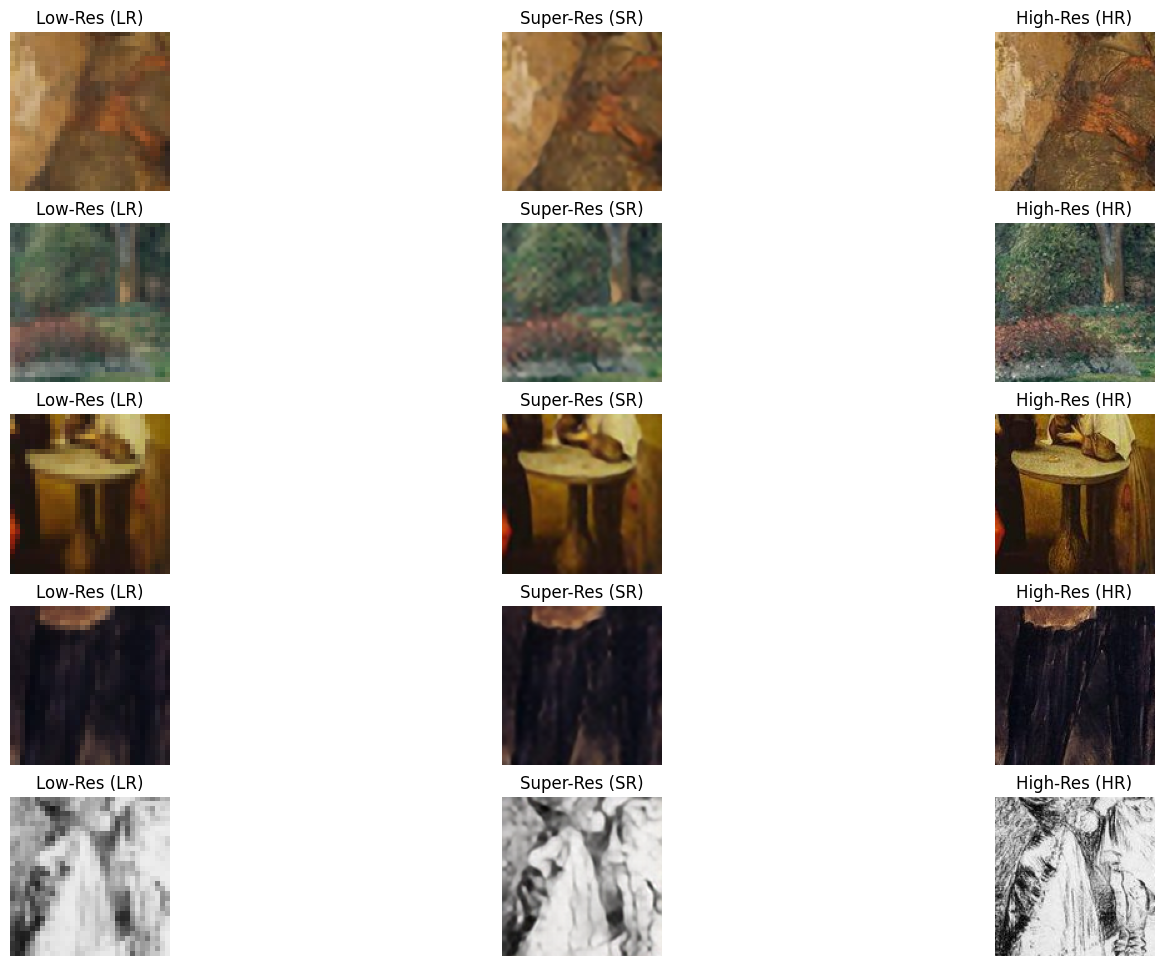

In [ ]:
# Image Resokution Visualization
print("Image Comparison")
show_results(sr_model, val_dataset, device, num_images=5)


In [ ]:
import time
import torch
sr_model.eval()
dummy = torch.randn (1,3,32,32).to(device) # Dummy input
for _ in range(10):
  _ = sr_model(dummy)
  if torch.cuda.is_available():
    torch.cuda.synchronize()
start_time = time.time()
_=sr_model(dummy)
if torch.cuda.is_available():
    torch.cuda.synchronize()
end_time = time.time()
inference_time = end_time - start_time # How long model takes to process one input image
fps = 1.0 / inference_time # How many images can the model process per second
print(f"\nInference time : {inference_time:.6f} seconds")
print(f"FPS: {fps:.2f} | Target : 30 FPS (0.03 s per frame)")


Inference time : 0.000625 seconds
FPS: 1599.66 | Target : 30 FPS (0.03 s per frame)


# IMPORTANT
Make sure your model definition in `models.py` has the class name
`SuperResolutionModel` and make sure you save your weights as `model.pth` e.g.
`torch.save(model, 'model.pth')`.

**DO NOT** submit a model which has more than 5 Million parameters. We will
reject in the backend.

In [ ]:
def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_model_parameters(sr_model)
if total_params > 5000000:
    print("Model greater than 5 million params!! Reduce model complexity!!")
else:
    torch.save(sr_model.state_dict(), 'model.pth')